# GloFAS - extract time series
***

**Author:** Chus Casado Rodríguez<br>
**Date:** 18-09-2023<br>

**Introduction:**<br>


In [15]:
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
import yaml

import warnings
warnings.filterwarnings('ignore')

In [16]:
import geopandas as gpd

### Configuration

In [17]:
with open('config_extraction.yml', 'r', encoding='utf8') as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)

path_res = Path(cfg['path_res'])
path_ts = Path(cfg['path_ts'])
path_out = Path(cfg['path_out'])
if path_out.exists() is False:
    path_out.mkdir()
var = cfg['var']

In [18]:
path_datasets = Path('Z:/nahaUsers/casadje/datasets/')

### ResOpsUS

In [19]:
# import shapefile
path_ResOps = Path(path_datasets / 'reservoirs' / 'ResOpsUS')
resops = gpd.read_file(path_ResOps / 'GIS' / 'reservoirs.shp')
resops.set_index('DAM_ID', drop=True, inplace=True)

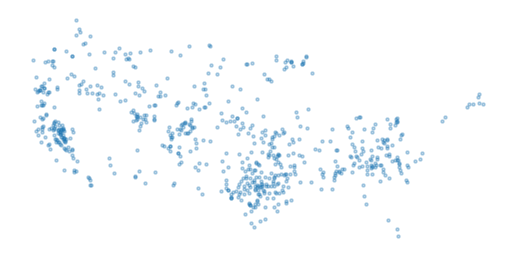

In [20]:
# plot reservoir locations
fig, ax = plt.subplots()
ax.scatter(resops.geometry.x, resops.geometry.y, s=5, alpha=.3)
ax.set_aspect('equal')
ax.axis('off');

### GloFAS
#### Shapefile

In [21]:
# load GloFAS reservoirs
path_GloFAS = Path('../data/reservoirs/GloFAS')
glofas_shp = gpd.read_file(path_GloFAS / 'GloFAS_reservoirs.shp')
glofas_shp.GRAND_ID = glofas_shp.GRAND_ID.astype(pd.Int64Dtype())
glofas_shp.GLWD_ID = glofas_shp.GLWD_ID.astype(pd.Int64Dtype())
glofas_shp.set_index('GRAND_ID', inplace=True)

# keep only reservoirs in ResOpsUS
mask = glofas_shp.index.intersection(resops.index)
glofas_shp = glofas_shp.loc[mask]

# remove duplicates
glofas_shp = glofas_shp[~glofas_shp.index.duplicated(keep='first')]

glofas_shp.sort_index(axis=0, inplace=True)

#### Raster

In [22]:
# load static map of reservoirs
glofas_raster = xr.open_dataset(path_res)['res']

# extract an array of reservoir ID
# ids = np.unique(glofas_raster.where(~glofas_raster.isnull(), drop=True))
# ids = ids[~np.isnan(ids) & (ids != -9999)]
# ids = ids.astype(int)
ids = glofas_shp.ResID.sort_values().values

In [23]:
# xr.DataArrays of reservoir longitudes and latitudes
lon = xr.DataArray(np.nan, dims=['ResID'], coords={'ResID': ids})
lat = xr.DataArray(np.nan, dims=['ResID'], coords={'ResID': ids})
for id in tqdm(ids):
    cell = glofas_raster.where(glofas_raster == id, drop=True)
    lon.loc[dict(ResID=id)] = cell.lon.data[0]
    lat.loc[dict(ResID=id)] = cell.lat.data[0]
coords = xr.Dataset({'lon': lon, 'lat': lat})

  0%|          | 0/121 [00:00<?, ?it/s]

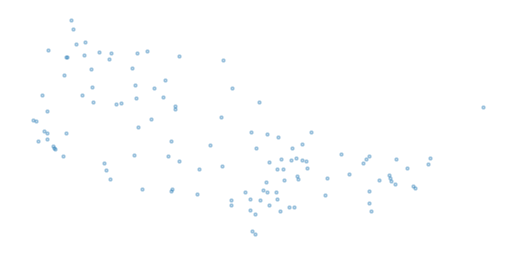

In [24]:
# plot reservoir locations
fig, ax = plt.subplots()
ax.scatter(lon.data, lat.data, s=5, alpha=.3)
ax.set_aspect('equal')
ax.axis('off');

In [27]:
coords

<xarray.Dataset>
Dimensions:  (ResID: 121)
Coordinates:
  * ResID    (ResID) int64 7 12 14 16 17 18 30 ... 581 609 617 621 623 635 638
Data variables:
    lon      (ResID) float64 -95.33 -96.58 -109.2 ... -118.5 -111.5 -114.8
    lat      (ResID) float64 38.92 39.27 44.48 36.52 ... 44.48 52.07 36.98 36.07

### Time series of reservoir storage

In [14]:
for file in tqdm(glob.glob(f'{path_ts}/{var}_*.nc')):
    
    # check if the data was already processed
    filename = file.split('\\')[-1]
    fileout = path_out / filename.replace('.nc', f'_extract{len(ids)}.nc')
    if fileout.exists():
        continue
        
    # load GRIB file
    da = xr.open_dataset(file, chunks={'time': 1})[var]

    # extract time series for each ID
    da_extract = xr.DataArray(dims=['time', 'ResID'], coords={'time': da.time, 'ResID': ids}, name=var, attrs=da.attrs)
    for id in tqdm(ids):
        lon, lat = coords.sel(ResID=id)['lon'].data, coords.sel(ResID=id)['lat'].data
        da_extract.loc[{'ResID': id}] = da.sel(lon=lon, lat=lat, method='nearest').drop(['lon', 'lat'])
    
    # export extraction
    da_extract.to_netcdf(fileout)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/121 [00:00<?, ?it/s]